In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("Sarcasm_Final_Dataset_Benchmark - Sheet1.csv")

In [ ]:
data['Text'] = data['Text'].astype(str)
data.head()

,article_link,Text,Label
0,https://www.huffingtonpost.com/entry/trump-par...,donald trump insists he has the 'complete powe...,0
1,https://entertainment.theonion.com/woman-who-a...,woman who admits to having watched golden glob...,1
2,https://entertainment.theonion.com/eva-longori...,eva longoria tans self out of visible spectrum,1
3,https://www.theonion.com/horrified-pope-calls-...,horrified pope calls philadelphia humanity's g...,1
4,https://www.huffingtonpost.com/entry/the-enigm...,the enigmatic art of josef koudelka,0


In [ ]:
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics

In [ ]:
!pip3 install bert-for-tf2

     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=24f144a27b2f2fc154cbd2628d718057fdbe663c4026bf353c1a672b79aca2a0
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=169ccab7fce0de5dd2893a1b2b291af22abed81acb73090cee8fdd2a011b580a
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=b339a7ba7d6e6715626a64dfb108d4116b47178b6af0da2228bb1b53bf06a55a
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:
import tensorflow_hub as hub 
from bert import bert_tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
max_len = 100
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(data.Text, data['Label'], 
                                                                          test_size=0.2, random_state=0)
# print(X_train['Text'])
# X_train['Text'] = X_train['Text'].apply(lambda x : string(x))
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    X_train, y_train, 
   
    epochs=5,
    callbacks=[checkpoint, earlystopping],
    batch_size=1,
    verbose=1
)

Epoch 1/5
3199/3199 [==============================] - 201s 58ms/step - loss: 0.4233 - accuracy: 0.8109


Epoch 2/5
3199/3199 [==============================] - 187s 58ms/step - loss: 0.1789 - accuracy: 0.9394


Epoch 3/5
3199/3199 [==============================] - 187s 58ms/step - loss: 0.0779 - accuracy: 0.9762


Epoch 4/5
3199/3199 [==============================] - 187s 58ms/step - loss: 0.0472 - accuracy: 0.9884


Epoch 5/5
3199/3199 [==============================] - 186s 58ms/step - loss: 0.0352 - accuracy: 0.9912


CPU times: user 14min 49s, sys: 17.9 s, total: 15min 7s
Wall time: 15min 47s


In [ ]:
train_history.history

{'accuracy': [0.8108783960342407,
  0.9393560290336609,
  0.9762426018714905,
  0.9884338974952698,
  0.9912472367286682],
 'loss': [0.4232807755470276,
  0.17889821529388428,
  0.07786460220813751,
  0.047165848314762115,
  0.03524671494960785]}

In [ ]:
print(X_val[0])

[[  101  2402  8037 ...     0     0     0]
 [  101  5996  2450 ...     0     0     0]
 [  101  5057  3626 ...     0     0     0]
 ...
 [  101  1052  8873 ...     0     0     0]
 [  101 11503  2611 ...     0     0     0]
 [  101  2643  3294 ...     0     0     0]]


In [ ]:
test_performance=model.evaluate(X_val,y_val)
print((test_performance))
print("The loss of the model on the test set : {}".format(test_performance[0]))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))
y_pred = model.predict(X_val)

25/25 [==============================] - 6s 218ms/step - loss: 0.5943 - accuracy: 0.8863
[0.5942677855491638, 0.8862500190734863]
The loss of the model on the test set : 0.5942677855491638
The accuracy of the model on the test set : 88.62500190734863%


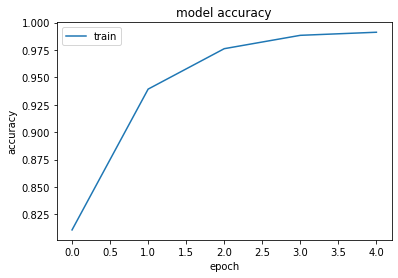

In [ ]:
plt.plot(train_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

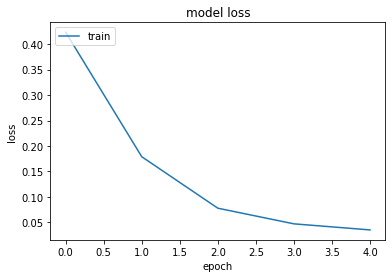

In [ ]:
plt.plot(train_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = np.round(y_pred)

In [ ]:
from sklearn.metrics import f1_score
print(f1_score(y_val, y_pred, average='macro'))
print(f1_score(y_val, y_pred, average='micro'))
print(f1_score(y_val, y_pred, average='weighted'))
print(f1_score(y_val, y_pred, average=None))
print(f1_score(y_val, y_pred, zero_division=1))

0.8810673227568202
0.88625
0.8844810622583159
[0.85624013 0.90589452]
0.905894519131334


In [ ]:
from sklearn.metrics import recall_score
print(recall_score(y_val, y_pred, average='macro'))
print(recall_score(y_val, y_pred, average='micro'))
print(recall_score(y_val, y_pred, average='weighted'))
print(recall_score(y_val, y_pred, average=None))
print(recall_score(y_val, y_pred, average=None, zero_division=1))

0.8740723045070871
0.88625
0.88625
[0.78550725 0.96263736]
[0.78550725 0.96263736]


In [ ]:
from sklearn.metrics import precision_score
print(precision_score(y_val, y_pred, average='macro'))
print(precision_score(y_val, y_pred, average='micro'))
print(precision_score(y_val, y_pred, average='weighted'))
print(precision_score(y_val, y_pred, average=None))
print(precision_score(y_val, y_pred, average=None, zero_division=1))

0.8982204861111112
0.88625
0.8923421223958334
[0.94097222 0.85546875]
[0.94097222 0.85546875]
